In [1]:
#-------------- Log -----------------#
# ======= 30.09.21 =======
# Adding Statistics class
# T+1 label
# Model callback: save_best_only=False
# ========================
# ======= 01.10.21 =======
# Sharpe(risk_free_rate) 0.00003 -> 0.025
# Fix - df_close's shape error: delete reduntdant rows/columns
# Fix - Unsupported object type float : cast train_x, test_d and enc_y to float data type
# Model callback: save_best_only=True
# ========================
# ======= 02.10.21 =======
# Sharpe(risk_free_rate) 0.025 -> 0.005
# create_label: pct_change() - periods 1 -> 3
# Model: CuDNNLSTM -> Stacked LSTM
# ========================
# ======= 03.10.21 =======
# create-label: percentage change of df_close[] apply qcut(label=False) change [1:] -> [3:] (Read and apply label from date of t+3)
# create_stock_data: R_future shift -1 -> -3
# create_stock_data: st_data['label'] + [np.nan] 1 -> 3
# ========================
# ======= 03.10.21 =======
# Update 5 ichimoku indicators 
# Model shape (240,1) -> (240,5)
# Adding "reshaper" function 
# LSTM first layer 50 -> 75
# scarlar_normalize StandardSclaer -> RobustScaler
# ======= 20.11.21 =======
# Change np.random seed for reproducibility

In [2]:
# import 
import pandas as pd
import numpy as np
import random

import time
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout,Dense,Input, LSTM 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import optimizers
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive, files
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
# Environment
import os
SEED = 7773
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED) # for reproducibility
tf.random.set_seed(SEED) # for reproducibility

In [4]:
# Statistic Class
import scipy.stats

class Statistics:
    def __init__(self,series):
        self.series = np.array(series)
        self.n = len(series)
    def mean(self):
        return np.mean(self.series)
    def std(self):
        return np.std(self.series)
    def stderr(self):
        return scipy.stats.sem(self.series)
    def percentiles(self,p=[.25,.5,.75]):
        return pd.Series(self.series).describe(percentiles=p)
    def pos_perc(self):
        return 100*sum(self.series>0)/self.n
    def skewness(self):
        return scipy.stats.skew(self.series)
    def kurtosis(self):
        return scipy.stats.kurtosis(self.series)
    def VaR(self,confidence):
        indx = int(confidence*self.n/100)
        return sorted(self.series)[indx-1]
    def CVaR(self,confidence):
        indx = int(confidence*self.n/100)
        return sum(sorted(self.series)[:indx])/indx
    def MDD(self):
        money = np.cumprod(1+self.series/100)
        maximums = np.maximum.accumulate(money)
        drawdowns = 1 - money/maximums
        return np.max(drawdowns)
    # def sharpe(self,risk_free_rate = 0.005): # 0.0003 -> 0.005
    #     mu = self.mean()
    #     sig = self.std()
    #     sharpe_d = (mu-risk_free_rate)/sig
    #     return (252**0.5)*sharpe_d 
    def yearly_rets(self):
        total_ret = self.series
        return total_ret.sum(axis=0)    
    def shortreport(self):
        print('Mean \t\t',self.mean())
        print('Standard dev \t',self.std())
        print('Yearly Average Return \t',self.yearly_rets())
        # print('Sharpe ratio \t',self.sharpe())      
    def report(self):
        print('Mean \t\t',self.mean())
        print('Standard dev \t',self.std())
        print('Yearly Average Return \t',self.yearly_rets())
        # print('Sharpe ratio \t',self.sharpe())
        print('Standard Error \t',self.stderr())
        print('Share>0 \t',self.pos_perc())
        print('Skewness \t',self.skewness())
        print('Kurtosis \t',self.kurtosis())
        print('VaR_1 \t\t',self.VaR(1))
        print('VaR_2 \t\t',self.VaR(2))
        print('VaR_5 \t\t',self.VaR(5))
        print('CVaR_1 \t\t',self.CVaR(1))
        print('CVaR_2 \t\t',self.CVaR(2))
        print('CVaR_5 \t\t',self.CVaR(5))
        print('MDD \t\t',self.MDD())
        print(self.percentiles())

In [5]:
# Read VN30 data

label_file = '/content/drive/MyDrive/CS Graduation Project/Dataset/Data_240-3/VN30-Full.csv'

range1 = [i for i in range(0,108)] # drop 2021 columns
vn30_df = pd.read_csv(label_file, usecols=range1)
all_companies = list(set(vn30_df.values.flatten()))
all_companies.remove(np.nan)     
all_companies.sort()

companies =""
for company in all_companies:
  companies = companies +" "+ company

print(companies)

 BID BMP BVH CII CSM CTD CTG DHG DIG DPM DRC EIB FLC FPT GAS GMD HAG HCM HDB HHS HNG HPG HSG HVG IJC ITA KBC KDC KDH MBB MSN MWG NT2 NTL NVL OGC PET PGD PLX PNJ POW PPC PVD PVF PVT QCG REE ROS SAB SBT SJS SSI STB TCB TCH VCB VHM VIC VJC VNM VPB VSH


In [6]:
vn30_df.head()

,01/2012,02/2012,03/2012,04/2012,05/2012,06/2012,07/2012,08/2012,09/2012,10/2012,...,03/2020,04/2020,05/2020,06/2020,07/2020,08/2020,09/2020,10/2020,11/2020,12/2020
0,BVH,BVH,BVH,BVH,BVH,BVH,BVH,BVH,BVH,BVH,...,BID,BID,BID,BID,BID,BID,BID,BID,BID,BID
1,CII,CII,CII,CII,CII,CII,CII,CII,CII,CII,...,BVH,BVH,BVH,BVH,CTG,CTG,CTG,CTG,CTG,CTG
2,CTG,CTG,CTG,CTG,CTG,CTG,CTG,CTG,CTG,CTG,...,CTD,CTD,CTD,CTD,EIB,EIB,EIB,EIB,EIB,EIB
3,DIG,DIG,DIG,DIG,DIG,DIG,DIG,DIG,DIG,DIG,...,CTG,CTG,CTG,CTG,FPT,FPT,FPT,FPT,FPT,FPT
4,DPM,DPM,DPM,DPM,DPM,DPM,DPM,DPM,DPM,DPM,...,EIB,EIB,EIB,EIB,GAS,GAS,GAS,GAS,GAS,GAS


In [7]:
# Get constituents
constituents = {'-'.join(col.split('/')[::-1]):set(vn30_df[col].dropna()) 
                for col in vn30_df.columns}
print(constituents)

{'2012-01': {'KDH', 'REE', 'HAG', 'HVG', 'CII', 'IJC', 'DPM', 'BVH', 'VSH', 'CTG', 'SBT', 'VCB', 'QCG', 'FPT', 'PNJ', 'OGC', 'DIG', 'STB', 'EIB', 'VNM', 'KDC', 'VIC', 'SJS', 'SSI', 'ITA', 'GMD', 'PVF', 'HPG', 'MSN', 'PVD'}, '2012-02': {'KDH', 'REE', 'HAG', 'HVG', 'CII', 'IJC', 'DPM', 'BVH', 'VSH', 'CTG', 'SBT', 'VCB', 'QCG', 'FPT', 'PNJ', 'OGC', 'DIG', 'STB', 'EIB', 'VNM', 'KDC', 'VIC', 'SJS', 'SSI', 'ITA', 'GMD', 'PVF', 'HPG', 'MSN', 'PVD'}, '2012-03': {'KDH', 'REE', 'HAG', 'HVG', 'CII', 'IJC', 'DPM', 'BVH', 'VSH', 'CTG', 'SBT', 'VCB', 'QCG', 'FPT', 'PNJ', 'OGC', 'DIG', 'STB', 'EIB', 'VNM', 'KDC', 'VIC', 'SJS', 'SSI', 'ITA', 'GMD', 'PVF', 'HPG', 'MSN', 'PVD'}, '2012-04': {'KDH', 'REE', 'HAG', 'HVG', 'CII', 'IJC', 'DPM', 'BVH', 'VSH', 'CTG', 'SBT', 'VCB', 'QCG', 'FPT', 'PNJ', 'OGC', 'DIG', 'STB', 'EIB', 'VNM', 'KDC', 'VIC', 'SJS', 'SSI', 'ITA', 'GMD', 'PVF', 'HPG', 'MSN', 'PVD'}, '2012-05': {'KDH', 'REE', 'HAG', 'HVG', 'CII', 'IJC', 'DPM', 'BVH', 'VSH', 'CTG', 'SBT', 'VCB', 'QCG', 'FPT

In [8]:
constituents_train = {} 
for test_year in range(2015,2018):
    months = [str(t)+'-0'+str(m) if m<10 else str(t)+'-'+str(m) 
              for t in range(test_year-3,test_year) for m in range(1,13)]
    constituents_train[test_year] = [list(constituents[m]) for m in months]
    constituents_train[test_year] = set([i for sublist in constituents_train[test_year] 
                                         for i in sublist])

In [9]:
print(constituents_train)

{2015: {'HSG', 'KDH', 'REE', 'HAG', 'HVG', 'CII', 'IJC', 'DPM', 'BVH', 'VSH', 'FLC', 'CTG', 'SBT', 'VCB', 'QCG', 'FPT', 'PNJ', 'DRC', 'OGC', 'DIG', 'PPC', 'STB', 'PGD', 'CSM', 'PET', 'PVT', 'EIB', 'VNM', 'KDC', 'NTL', 'VIC', 'SJS', 'HCM', 'SSI', 'ITA', 'MBB', 'GMD', 'PVF', 'HPG', 'MSN', 'PVD'}, 2016: {'HSG', 'REE', 'HAG', 'HVG', 'CII', 'IJC', 'DPM', 'BVH', 'VSH', 'FLC', 'CTG', 'SBT', 'VCB', 'FPT', 'PNJ', 'KBC', 'DRC', 'OGC', 'DIG', 'PPC', 'STB', 'CSM', 'PGD', 'PET', 'PVT', 'EIB', 'VNM', 'KDC', 'VIC', 'HCM', 'SSI', 'ITA', 'MBB', 'GMD', 'PVF', 'HHS', 'HPG', 'MSN', 'PVD'}, 2017: {'HSG', 'REE', 'BID', 'HAG', 'HNG', 'HVG', 'CII', 'IJC', 'DPM', 'BVH', 'VSH', 'FLC', 'MWG', 'CTG', 'SBT', 'NT2', 'VCB', 'FPT', 'KBC', 'DRC', 'OGC', 'PPC', 'PGD', 'STB', 'CSM', 'PET', 'PVT', 'EIB', 'VNM', 'KDC', 'VIC', 'HCM', 'SSI', 'ITA', 'MBB', 'GAS', 'GMD', 'HHS', 'HPG', 'MSN', 'PVD'}}



**Def Functions**

In [10]:
# ---- Model Stacked LSTM ----#
def makeLSTM():
    inputs = Input(shape=(240,5))   
    # x = LSTM(25,return_sequences = False)(inputs)
    
    x = LSTM(25, return_sequences = True)(inputs)
    x = LSTM(25, return_sequences = False)(x)
    x = Dense(16)(x)

    x = Dropout(0.1)(x)
    outputs = Dense(2,activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(),
                          metrics=['accuracy'])
    model.summary()
    return model

#-----------------------------------------------------------------------------
# ---- Call Back ----#
def callbacks_req(model_type='LSTM'):
    csv_logger = CSVLogger(model_folder+'/training-log-'+model_type+'-'+str(test_year)+'.csv')
    filepath = model_folder+"/model-" + model_type + '-' + str(test_year) + "-240-E{epoch:02d}.h5"
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True)
    earlyStopping = EarlyStopping(monitor='val_loss',mode='min',patience=10,restore_best_weights=True)
    return [csv_logger,earlyStopping,model_checkpoint]
#-----------------------------------------------------------------------------

# ---- Reshape ----#
def reshaper(arr):
    arr = np.array(np.split(arr,5,axis=1))
    arr = np.swapaxes(arr,0,1)
    arr = np.swapaxes(arr,1,2)
    return arr    
#-----------------------------------------------------------------------------
# ---- Train ----#
def trainer(train_data,test_data):

    np.random.shuffle(train_data)
    train_x,train_y= train_data[:,2:-2], train_data[:,-1]
    train_x = np.reshape(train_x, (len(train_x),240,5)).astype(np.float32)
    train_y = np.reshape(train_y,(-1, 1))
    
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(train_y)
    enc_y = enc.transform(train_y).toarray().astype(np.float32)

    model = makeLSTM()
    callbacks = callbacks_req()
    
    history = model.fit(train_x,
              enc_y,
              epochs=200,
              validation_split=0.2,
              callbacks=callbacks,
              batch_size=64
              )

    dates = list(set(test_data[:,0]))
    predictions = {}
    for day in dates:
        test_d = test_data[test_data[:,0]==day]
        test_d = np.reshape(test_d[:,2:-2], (len(test_d),240,5)).astype(np.float32)
        predictions[day] = model.predict(test_d)[:,1]
    return history, model,predictions

#-----------------------------------------------------------------------------
# ---- Load Trained model and Make Hypothesis ----#
def trained(filename,train_data,test_data):
    model = load_model(filename)
    dates = list(set(test_data[:,0]))
    predictions = {}

    for day in dates:
        test_d = test_data[test_data[:,0]==day]
        test_d = np.reshape(test_d[:,2:-2],(len(test_d),240,5)).astype(np.float32)
        predictions[day] = model.predict(test_d)[:,1]
    return model,predictions

#-----------------------------------------------------------------------------
# ---- Simulate ----#
def simulate(test_data,predictions):
    rets = pd.DataFrame([],columns=['Long'])
    pd_index = pd.DataFrame([],columns=['Index'])
    k = 3 # 10 -> 3
    for day in sorted(predictions.keys()):
        preds = predictions[day]
        test_returns = test_data[test_data[:,0]==day][:,[1,-2]]
        top_preds = predictions[day].argsort()[-k:][::-1] 
        trans_long = test_returns[top_preds]
        rets.loc[day] = [np.mean(trans_long[0:,1])]
        pd_index.loc[day] = trans_long[0,0] +'-'+ trans_long[1,0] +'-'+ trans_long[2,0]

        inyear_index = []
        for i, row in pd_index.iterrows():
          arr = row[0].split('-')
          inyear_index.append(arr[0])
          inyear_index.append(arr[1])
          inyear_index.append(arr[2])  
        count_index = {i:inyear_index.count(i) for i in inyear_index}

    print('Result : ',rets.mean())  
    return pd_index, count_index, rets

#-----------------------------------------------------------------------------
# ---- Label Creation for t+3 change ----#    
def create_label(df_close,perc=[0.5,0.5]):
    perc = [0.]+list(np.cumsum(perc))
    label = df_close.iloc[:,1:].pct_change(fill_method=None, periods=10).fillna(0)[10:].apply( # periods 0 -> 3
            lambda x: pd.qcut(x.rank(method='first'),perc,labels=False), axis=1)
    label = label.fillna(0)
    return label

#-----------------------------------------------------------------------------
# ---- Generate Feature Data ----#
def create_stock_data(df_close,st,m=240):
    st_data = pd.DataFrame([])
    st_data['Date'] = list(df_close['Date'])
    st_data['Name'] = [st]*len(st_data)

    # 240 Rets Future 
    daily_change = df_close[st].pct_change(periods=10) # 3 -> 10
    for k in range(m)[::-1]:
        st_data['R'+str(k)] = daily_change.shift(k)

    # 240 rets ichimoku indicators
    tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span, inx_close = ichimoku_calculating(st)
    ichimoku1 = tenkan_sen.div(kijun_sen).replace(np.inf, 0)
    for k in range(m)[::-1]:
        st_data['tenkan/kijun'+str(k)] = ichimoku1.shift(k)
    ichimoku2 = senkou_span_a.div(senkou_span_b).replace(np.inf, 0)
    for k in range(m)[::-1]:
        st_data['span(a/b)'+str(k)] = ichimoku2.shift(k).shift(k)
    ichimoku3 = tenkan_sen.div(inx_close).replace(np.inf, 0)    
    for k in range(m)[::-1]:
        st_data['tenkan/close'+str(k)] = ichimoku3.shift(k)
    ichimoku4 = senkou_span_a.div(inx_close).replace(np.inf, 0)    
    for k in range(m)[::-1]:
        st_data['span(a)/close'+str(k)] = ichimoku4.shift(k) 

    st_data['R-future'] = daily_change.shift(-10) # -1 -> -3 -> -10    
    st_data['label'] = list(label[st])+10*[np.nan]
    st_data['Month'] = list(df_close['Date'].str[:-3])
    
    st_data = st_data.dropna()
    
    trade_year = st_data['Month'].str[:4]
    st_data = st_data.drop(columns=['Month'])
    st_train_data = st_data[trade_year<str(test_year)]
    st_test_data = st_data[trade_year==str(test_year)]
    return np.array(st_train_data),np.array(st_test_data)

#-----------------------------------------------------------------------------
# ---- Normalize ----#
def scalar_normalize(train_data,test_data, norm_type):
    scaler = StandardScaler() if norm_type=='StandardScaler' else RobustScaler()
    scaler.fit(train_data[:,2:-2])
    train_data[:,2:-2] = scaler.transform(train_data[:,2:-2])
    test_data[:,2:-2] = scaler.transform(test_data[:,2:-2])

#-----------------------------------------------------------------------------
# ---- Generate Ichimoku Indicators  ----#
def ichimoku_calculating(st):
    # Read Index
    file_name = '/content/drive/MyDrive/CS Graduation Project/Dataset/Data_240-3/Cophieu68 Vn30-All/'+str(st)+'.csv'
    df_index = pd.read_csv(file_name, parse_dates=[1])
    # Sort date in ascending 
    df_index.sort_values('<DTYYYYMMDD>',inplace=True)

    # Tenkan Sen - past 9 days
    highest_hi9 = df_index['<High>'].rolling(window=9).max()
    lowest_low9 = df_index['<Low>'].rolling(window=9).min()
    tenkan_sen = (lowest_low9 + highest_hi9)/2

    # Kijun Sen - past 26 days
    highest_hi26 = df_index['<High>'].rolling(window=26).max()
    lowest_low26 = df_index['<Low>'].rolling(window=26).min()
    kijun_sen = (highest_hi26 + lowest_low26)/2

    # Leading Span 1 - 26 days ahead from today
    senkou_a = ((tenkan_sen + kijun_sen)/2).shift(26)

    # Leading Span 2 - past 52 days, plotted 26 days ahead from today
    highest_hi52 = df_index['<High>'].rolling(window=52).max()
    lowest_low52 = df_index['<Low>'].rolling(window=52).min()
    senkou_b = ((highest_hi52 +lowest_low52 )/2).shift(26)

    # The most current closing price plotted 26 time periods behind
    chikou_span = df_index['<Close>'].shift(-26)    

    return tenkan_sen.fillna(0), kijun_sen.fillna(0), senkou_a.fillna(0), senkou_b.fillna(0), chikou_span.fillna(0), df_index['<Close>']
def daily_indexes(test_data, predictions):
  k = 3
  rets = pd.DataFrame([],columns=['Long'])
  pd_index = pd.DataFrame([],columns=['Index'])
  for day in sorted(predictions.keys()):
    test_returns = test_data[test_data[:,0]==day][:,[1,-2]]
    top_preds = predictions[day].argsort()[-k:][::-1] 
    trans_long = test_returns[top_preds]
    rets.loc[day] = [np.mean(trans_long[0:,1])]
    pd_index.loc[day] = trans_long[0,0] +'-'+ trans_long[1,0] +'-'+ trans_long[2,0]
  return pd_index  

#-----------------------------------------------------------------------------
# ---- functions for splitted-trading strategy ----#        
def split_equal(value, times):
    return [round(value // times, 0) + (1 if x < value % times else 0)  for x in range (times)]

def print_yearly_rets(investment, original_asset, invest_asset):
  yearly1 = invest_asset[0]/original_asset[0] - 1
  yearly2 = invest_asset[1]/original_asset[1] - 1 
  yearly3 = invest_asset[2]/original_asset[2] - 1

  total_asset = sum(invest_asset)
  total_year_rets = total_asset/investment - 1
  sign1, sign2, sign3, sign4 = '', '', '', ''
  if float(yearly1) >= 0:
    sign1 = '+'
  if float(yearly2) >= 0:
    sign2 = '+'
  if float(yearly3) >= 0:
    sign3 = '+'    
  if float(total_year_rets) >= 0:
    sign4 = '+'  

  print('Investment: '+str(investment))  
  print('Original Splitted Asset: '+str(original_asset[0])+' - '+str(original_asset[0])+' - '+str(original_asset[0]))
  print('Asset 1('+sign1+str(round(yearly1*100, 2))+'%): '+str(invest_asset[0]))  
  print('Asset 2('+sign2+str(round(yearly2*100, 2))+'%): '+str(invest_asset[1])) 
  print('Asset 3('+sign3+str(round(yearly3*100, 2))+'%): '+str(invest_asset[2]))   
  print('-'*45)
  print('Total Asset ('+sign4+str(round(total_year_rets*100, 3))+'%): '+str(total_asset))

def split_trade_simulation(avg_rets):
  count=0
  investment = 100000000
  original_asset = split_equal(investment, 3)
  invest_asset = np.array(original_asset).astype(float)

  avg_rets['long2'] = avg_rets.iloc[:,0].shift(-1).fillna(0)
  avg_rets['long3'] = avg_rets.iloc[:,0].shift(-2).fillna(0)
  count = 10
  for index, rets in avg_rets.iterrows():
    if count==10:
      invest_asset[0] = invest_asset[0]*(1-0.0015)*(1+rets['Long'])*0.9975
      invest_asset[1] = invest_asset[1]*(1-0.0015)*(1+rets['long2'])*0.9975
      invest_asset[2] = invest_asset[2]*(1-0.0015)*(1+rets['long3'])*0.9975
      count=1
    count+=1  
  print_yearly_rets(investment, original_asset, invest_asset)
#-----------------------------------------------------------------------------  
#-----------------------------------------------------------------------------
# ---- function for single trading strategy ----#   
def single_trade_simulation(avg_rets):
  count=10
  investment = 100000000
  asset = investment
  avg_trade = []
  for rets in avg_rets.iloc[:,0]:
    if count==10:
      avg_trade.append(rets)
      asset = asset*(1-0.0015)*(1+rets)*0.9975
      count=1
    count+=1         
  yearly_rets = (asset/investment) - 1

  sign = ''
  if float(yearly_rets) >= 0:
      sign = '+'
  print('Asset('+sign+str(round(yearly_rets*100, 2))+'%): '+str(asset))
  return np.mean(avg_trade)   

#-----------------------------------------------------------------------------
# ---- Plot accuracy/epochs ----# 
def acc_plot(model_history, test_year):
  training_acc = model_history.history['accuracy']
  test_acc = model_history.history['val_accuracy']

  # Create count of the number of epochs
  epoch_count = range(1, len(training_acc) + 1)

  # Visualize loss history
  plt.plot(epoch_count, training_acc, 'r--')
  plt.plot(epoch_count, test_acc, 'b-')
  plt.legend(['Training Accuracy', 'Test Accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.savefig('/content/drive/MyDrive/CS Graduation Project/Source Code/Intraday Prediction/pct_ichimoku/history/model_figure-'+str(test_year)+'.jpeg')
  plt.show();

In [11]:
model_folder   = '/content/drive/MyDrive/CS Graduation Project/Source Code/Intraday Prediction/pct_ichimoku/model/'
result_folder  = '/content/drive/MyDrive/CS Graduation Project/Source Code/Intraday Prediction/pct_ichimoku/result/'
history_folder = '/content/drive/MyDrive/CS Graduation Project/Source Code/Intraday Prediction/pct_ichimoku/history/'
# for directory in [model_folder,result_folder]:
#     if not os.path.exists(directory):
#         os.makedirs(directory)

avg_returns.txt is rewriting...
----------------------------------------
2015
----------------------------------------
(12593, 1204) (6902, 1204) 46.228631258010864
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 5)]          0         
                                                                 
 lstm (LSTM)                 (None, 240, 25)           3100      
                                                                 
 lstm_1 (LSTM)               (None, 25)                5100      
                                                                 
 dense (Dense)               (None, 16)                416       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)            

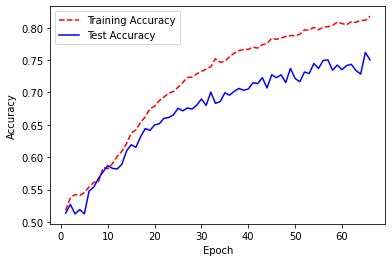


-- Single --
Asset(+33.21%): 133205521.9759702

-- Splitted --
Investment: 100000000
Original Splitted Asset: 33333334 - 33333334 - 33333334
Asset 1(+33.21%): 44401841.54669358
Asset 2(+16.35%): 38781822.82919147
Asset 3(+46.0%): 48665156.07363115
---------------------------------------------
Total Asset (+31.849%): 131848820.44951619
----------------------------------------
2016
----------------------------------------
(12170, 1204) (7110, 1204) 37.68914556503296
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 5)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 240, 25)           3100      
                                                                 
 lstm_3 (LSTM)               (None, 25)                5100      
                                                   

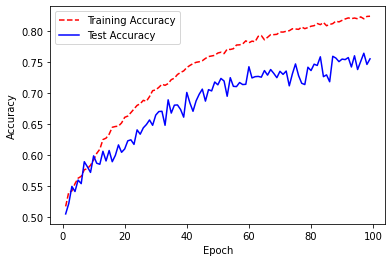


-- Single --
Asset(+17.24%): 117238518.79500172

-- Splitted --
Investment: 100000000
Original Splitted Asset: 33333334 - 33333334 - 33333334
Asset 1(+17.24%): 39079507.0465907
Asset 2(+6.89%): 35630942.343392946
Asset 3(+22.12%): 40707300.79990423
---------------------------------------------
Total Asset (+15.418%): 115417750.18988788
----------------------------------------
2017
----------------------------------------
(11451, 1204) (6724, 1204) 38.411428689956665
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 5)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 240, 25)           3100      
                                                                 
 lstm_5 (LSTM)               (None, 25)                5100      
                                                 

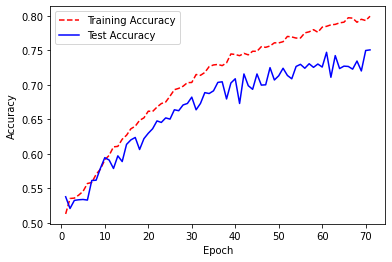


-- Single --
Asset(+21.41%): 121405291.94247775

-- Splitted --
Investment: 100000000
Original Splitted Asset: 33333334 - 33333334 - 33333334
Asset 1(+21.41%): 40468431.4568612
Asset 2(+27.46%): 42486552.25067275
Asset 3(+16.74%): 38914786.55868152
---------------------------------------------
Total Asset (+21.87%): 121869770.26621547
----------------------------------------
2018
----------------------------------------
(10283, 1204) (6426, 1204) 38.43576431274414
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 5)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 240, 25)           3100      
                                                                 
 lstm_7 (LSTM)               (None, 25)                5100      
                                                   

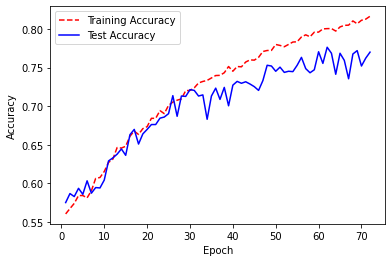


-- Single --
Asset(-23.56%): 76442636.19956161

-- Splitted --
Investment: 100000000
Original Splitted Asset: 33333334 - 33333334 - 33333334
Asset 1(-23.56%): 25480879.242804803
Asset 2(-22.86%): 25714838.611945584
Asset 3(+4.78%): 34926756.915873446
---------------------------------------------
Total Asset (-13.878%): 86122474.77062383
----------------------------------------
2019
----------------------------------------
(10709, 1204) (5640, 1204) 37.80325746536255
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 5)]          0         
                                                                 
 lstm_8 (LSTM)               (None, 240, 25)           3100      
                                                                 
 lstm_9 (LSTM)               (None, 25)                5100      
                                                 

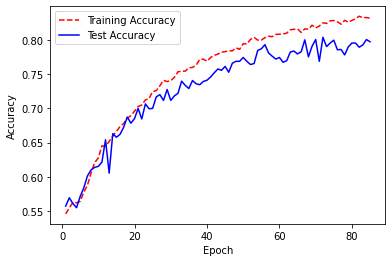


-- Single --
Asset(+10.56%): 110561566.8035046

-- Splitted --
Investment: 100000000
Original Splitted Asset: 33333334 - 33333334 - 33333334
Asset 1(+10.56%): 36853856.33824532
Asset 2(+22.31%): 40768880.395443395
Asset 3(+4.11%): 34704794.1156844
---------------------------------------------
Total Asset (+12.328%): 112327530.8493731
----------------------------------------
2020
----------------------------------------
(11188, 1204) (5324, 1204) 38.601242780685425
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 240, 5)]          0         
                                                                 
 lstm_10 (LSTM)              (None, 240, 25)           3100      
                                                                 
 lstm_11 (LSTM)              (None, 25)                5100      
                                                   

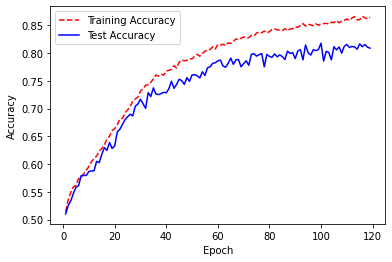


-- Single --
Asset(+25.12%): 125116165.92682007

-- Splitted --
Investment: 100000000
Original Splitted Asset: 33333334 - 33333334 - 33333334
Asset 1(+25.12%): 41705389.476381116
Asset 2(+14.32%): 38106348.943295985
Asset 3(+14.97%): 38322253.84525427
---------------------------------------------
Total Asset (+18.134%): 118133992.26493138


In [12]:
rets_file = result_folder+'avg_returns.txt'
if os.path.exists(rets_file):
    os.remove(rets_file)
    print('avg_returns.txt is rewriting...') 
norm_type = 'StandardScaler'    
for test_year in range(2015,2021):
    
    print('-'*40)
    print(test_year)
    print('-'*40)

    filename = '/content/drive/MyDrive/CS Graduation Project/Dataset/Data_240-3/Fixed Data/Close-'+str(test_year-3)+'.csv'
    df_close = pd.read_csv(filename)
    df_close = df_close.dropna(subset=['Date']) # Drop redundant rows
    df_close = df_close.dropna(axis=1, how='all') # Drop redundant cols
    df_close.insert(loc=32, column='PVF', value=np.nan) # insert delisted index column - PVF

    label = create_label(df_close)
    stock_names = sorted(list(constituents[str(test_year-1)+'-12']))
    train_data,test_data = [],[]

    start = time.time()
    for st in stock_names:
        st_train_data,st_test_data = create_stock_data(df_close,st)
        train_data.append(st_train_data)
        test_data.append(st_test_data)
      
    train_data = np.concatenate([x for x in train_data])
    test_data = np.concatenate([x for x in test_data])
    
    scalar_normalize(train_data,test_data, norm_type)
    print(train_data.shape,test_data.shape,time.time()-start)

    history, model, predictions = trainer(train_data,test_data)
    np.save(history_folder+'model_history-'+str(test_year)+'.npy', history.history)

    ind_daily, count_index, returns = simulate(test_data,predictions)
    dayly_indexes = daily_indexes(test_data, predictions)
    result = Statistics(returns.sum(axis=1))

    # history=np.load(history_folder+'model_history-'+str(test_year)+'.npy',allow_pickle='TRUE').item()
    acc_plot(history,test_year)

    print('\n-- Single --')
    single_trade_simulation(returns)
    print('\n'+'-- Splitted --')
    split_trade_simulation(returns)

    
    # print('\nAverage returns prior to transaction charges')
    # result.shortreport() 

    with open(result_folder+'predictions-'+str(test_year)+'.pickle', 'wb') as handle:
        pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

    ind_daily.to_csv(result_folder+'ind_daily_rets-'+str(test_year)+'.csv')
    returns.to_csv(result_folder+'avg_daily_rets-'+str(test_year)+'.csv')
    with open(result_folder+"avg_returns.txt", "a") as myfile:
        res = '-'*30 + '\n'
        res += str(test_year) + '\n'
        res += 'Mean = ' + str(result.mean()) + '\n'
        res += 'Index Freq:'+'\n'
        for row in count_index:
          res += '  +-+' +str(row) +': '+str(count_index[row])+'\n'
        res += 'Average yearly returns = '+str(result.yearly_rets()) + '\n'
        res += '-'*30 + '\n'
        myfile.write(res)

In [ ]:
!pip install import-ipynb

source_path_file = '/content/drive/MyDrive/CS Graduation Project/Source Code/Intraday Prediction/trade_plot.ipynb'
source_path_file = source_path_file.replace(' ', '\\ ')

import import_ipynb
from trade_plot.ipynb import trading_plot_main

trading_plot_main(result_folder+'avg_daily_rets-')